In [1]:
import numpy as np  # Linear algebra
import pandas as pd  # Data manipulation
import seaborn as sns  # Visualization
import matplotlib.pyplot as plt  # Visualization
import pickle

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error

!pip install wordcloud


In [2]:
# Load the training datasets
df = pd.read_json('/workspaces/Recipe-Ingredients/train.json')

In [3]:
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
df.shape

(39774, 3)

In [5]:
df.columns

Index(['id', 'cuisine', 'ingredients'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [7]:
df.describe()

,id
count,39774.000000
mean,24849.536959
std,14360.035505
min,0.000000
25%,12398.250000
50%,24887.000000
75%,37328.500000
max,49717.000000


In [8]:
# Check the unique types in the 'ingredients' column
print(df['ingredients'].apply(type).unique())  

[<class 'list'>]


In [9]:
df['ingredients'] = df['ingredients'].apply(lambda x: [ingredient.lower() for ingredient in x])

In [10]:
df.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

In [11]:
# Check the number of unique cuisines
df.cuisine.nunique()

20

In [12]:
# identify the different cuisines in the dataset
df.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [13]:
# Check the entries of each cuisines
df['cuisine'].value_counts()

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64

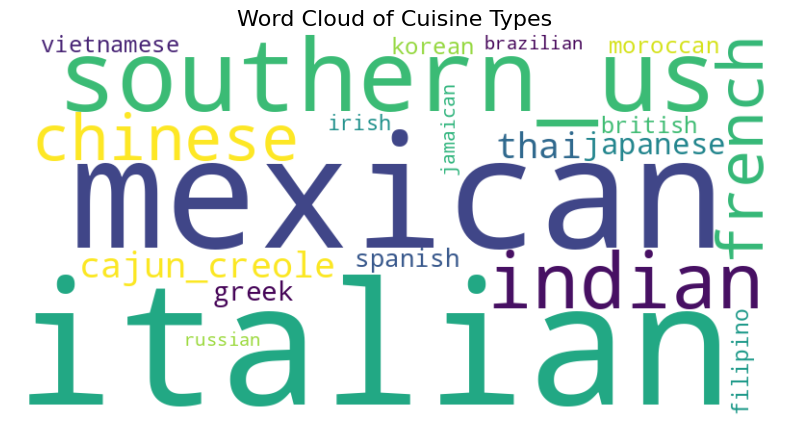

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the cuisine names into a single string
cuisine_text = ' '.join(df['cuisine'].values)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(cuisine_text)

# Display the word cloud
plt.figure(figsize=(10, 5))  # Set figure size
plt.imshow(wordcloud, interpolation='bilinear')  # Use bilinear interpolation for better quality
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of Cuisine Types', fontsize=16)  # Title
plt.show()

# Save the word cloud image (optional)
wordcloud.to_file('wordcloud.png')

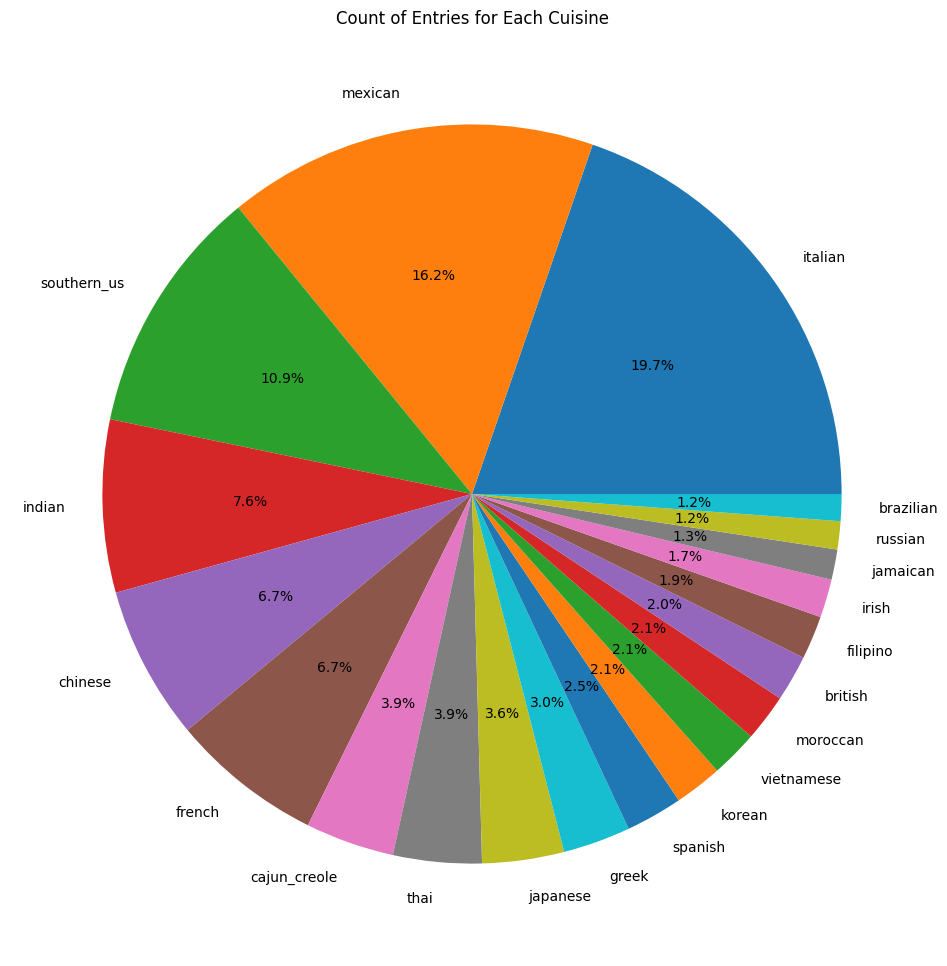

In [15]:
# Create a pie chart for count of entries for each cuisine
x = df['cuisine'].value_counts().index
y = df['cuisine'].value_counts().values
plt.figure(figsize=(14, 12)) 
plt.pie(y, labels=x, autopct='%1.1f%%')
plt.title('Count of Entries for Each Cuisine')
plt.savefig('Count_of_Entries).png')
plt.show()

In [16]:
# Sample 1000 entries from the dataset
sampled_df = df.sample(n=1000, random_state=1)  # Set random_state for reproducibility

**Create TF-IDF Matrix**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500, max_df=0.95, min_df=5)

In [18]:
# Join ingredients into a single string (if not done yet)
sampled_df['ingredients_joined'] = sampled_df['ingredients'].apply(lambda x: ', '.join(x))

In [19]:
# Create the TF-IDF matrix using the sampled data
tfidf_matrix = tfidf_vectorizer.fit_transform(sampled_df['ingredients_joined'])

**Build the Recommendation System**

In [20]:
# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

In [21]:
with open('cosine_similarity.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

In [22]:
# Function to get recommendations based on the recipe index
def get_recommendations(recipe_index, cosine_sim=cosine_sim, top_n=5):
    # Get the pairwise similarity scores for all recipes
    sim_scores = list(enumerate(cosine_sim[recipe_index]))
    
    # Sort the recipes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the top N most similar recipes
    sim_scores = sim_scores[1:top_n + 1]  # Exclude the first one (itself)
    
    # Get the recipe indices
    recipe_indices = [i[0] for i in sim_scores]
    
    # Return the top N similar recipes
    return df.iloc[recipe_indices]


In [23]:
# Get recommendations for the recipe at index 0
recommendations = get_recommendations(0)  
print(recommendations)

        id  cuisine                                        ingredients
965  14471   french  [lemon slices, ice cubes, fresh lemon juice, l...
823  36480  mexican  [cooked turkey, jalapeno chilies, leftover gra...
293   6115  mexican  [chicken broth, dried basil, salt, cooked shri...
776  40343  italian  [cannellini beans, pasta sauce, sliced black o...
84   43399   indian  [black peppercorns, cinnamon sticks, cardamom ...


In [24]:
# Get recommendations for a specific recipe index
test_index = 5 
recommended_recipes = get_recommendations(test_index)

# Display the recommended recipes
print(f"Recommendations for Recipe ID {df.iloc[test_index]['id']}:")
print(recommended_recipes[['id', 'cuisine', 'ingredients']])  

Recommendations for Recipe ID 6602:
        id  cuisine                                        ingredients
297  40283  italian  [kosher salt, butter, garlic, dry white wine, ...
244  39391  italian  [ground black pepper, reduced fat milk, smoked...
466  20757   french  [fresh rosemary, yellow bell pepper, anchovy f...
265  18389   indian  [clove, cilantro leaves, ghee, cinnamon, jeera...
953  38286   indian  [carrots, green chilies, cilantro leaves, onio...


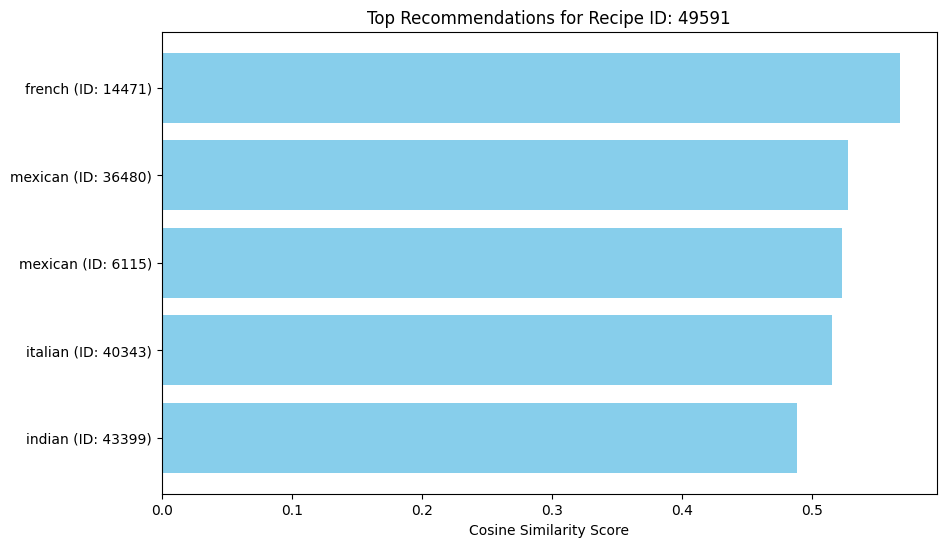

In [25]:
# Function to Visualize Recommendations with a BarPlot

def visualize_recommendations(recipe_index, recommendations):
    # Get the similarity scores for the recommendations
    sim_scores = cosine_sim[recipe_index][recommendations.index].flatten()
    
    # Sort the recommendations and their similarity scores
    sorted_indices = np.argsort(sim_scores)[::-1]
    sorted_recommendations = recommendations.iloc[sorted_indices]
    sorted_scores = sim_scores[sorted_indices]

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_recommendations['cuisine'] + ' (ID: ' + sorted_recommendations['id'].astype(str) + ')', 
             sorted_scores, color='skyblue')
    plt.xlabel('Cosine Similarity Score')
    plt.title('Top Recommendations for Recipe ID: {}'.format(sampled_df.iloc[recipe_index]['id']))
    plt.gca().invert_yaxis()  # Invert y axis to have the highest scores at the top
    plt.show()

# Visualize recommendations for the first recipe
visualize_recommendations(0, recommendations)


In [26]:
# Function to allow user to enter their preferred ingredients and get recommendations

def user_input_recommendations(user_ingredients, tfidf_vectorizer, sampled_df):
    # Transform user ingredients into TF-IDF
    user_tfidf = tfidf_vectorizer.transform([user_ingredients])
    
    # Calculate cosine similarity between user input and the TF-IDF matrix
    user_cosine_sim = cosine_similarity(user_tfidf, tfidf_matrix)
    
    # Get the indices of the most similar recipes
    similar_indices = user_cosine_sim.argsort().flatten()[::-1][:5]  # Top 5 recommendations
    
    # Return recommended recipes
    return sampled_df.iloc[similar_indices]

# Example usage
user_ingredients = "chicken, garlic, lemon"  # User inputs
user_recommendations = user_input_recommendations(user_ingredients, tfidf_vectorizer, sampled_df)
print(user_recommendations)

          id      cuisine                                        ingredients  \
29798    113      italian  [chicken breast halves, grated lemon peel, pes...   
25882   3326       french  [pepper, fresh lemon juice, grated lemon zest,...   
24441   8999      mexican  [vegetable oil, curly parsley, corn tortillas,...   
17521   4014  southern_us  [slivered almonds, lemon, fresh parsley, trout...   
9562   49245        greek  [golden raisins, garlic cloves, dried oregano,...   

                                      ingredients_joined  
29798  chicken breast halves, grated lemon peel, pest...  
25882  pepper, fresh lemon juice, grated lemon zest, ...  
24441  vegetable oil, curly parsley, corn tortillas, ...  
17521  slivered almonds, lemon, fresh parsley, trout,...  
9562   golden raisins, garlic cloves, dried oregano, ...  


**Test the Recommendation System**

In [27]:
# Load test dataset
test_df = pd.read_json('/workspaces/Recipe-Ingredients/test.json')

In [28]:
max_index = min(len(test_df), cosine_sim.shape[0])

In [29]:
# Prepare lists to store the actual and recommended ingredients
actual_ingredients = []
recommended_ingredients = []

In [30]:
for index in range(max_index):
    # Get recommendations based on the recipe index
    recommendations = get_recommendations(index)
    
    # Store the actual ingredients
    actual = test_df.iloc[index]['ingredients']
    actual_ingredients.append(set(actual))  # Store as a set for easier comparison
    
    # Store the recommended ingredients
    recommended = []
    for ingredient_list in recommendations['ingredients']:
        recommended.extend(ingredient_list)  # Flatten the list of lists into a single list
    
    recommended_ingredients.append(set(recommended))  # Store as a set

In [31]:
# Convert lists to numpy arrays for easier calculation
actual_ingredients_array = np.array(actual_ingredients)
recommended_ingredients_array = np.array(recommended_ingredients)

In [32]:
# Function to compute ingredient overlap
def compute_overlap(actual, recommended):
    return len(actual.intersection(recommended))  # Count of common ingredients

In [33]:
# Calculate overlaps
overlaps = [compute_overlap(actual, recommended) for actual, recommended in zip(actual_ingredients_array, recommended_ingredients_array)]


In [34]:
# Convert overlaps to an array
overlaps_array = np.array(overlaps)

In [35]:
# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(np.zeros(len(overlaps_array)), overlaps_array)  # Treat overlaps as the predictions
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 2.213


In [36]:
# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(np.zeros(len(overlaps_array)), overlaps_array))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 2.7711008642775887


Visualizing Ingredient Overlap to understand how ingredients in recommended recipes overlap with those in input recipes.

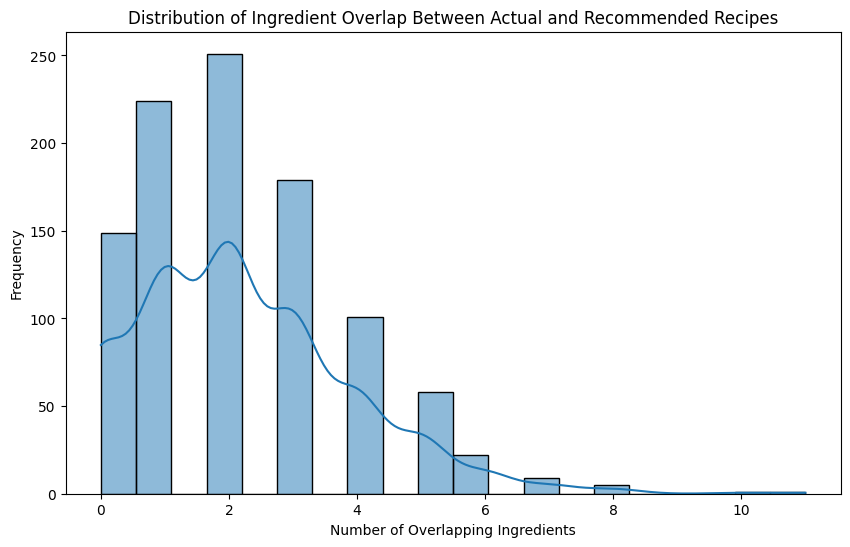

In [37]:
# function to get ingredient overlap
def plot_ingredient_overlap(actual, recommended):
    overlap_counts = [len(actual[i].intersection(recommended[i])) for i in range(len(actual))]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(overlap_counts, bins=20, kde=True)
    plt.title('Distribution of Ingredient Overlap Between Actual and Recommended Recipes')
    plt.xlabel('Number of Overlapping Ingredients')
    plt.ylabel('Frequency')
    plt.show()

# Use the actual and recommended ingredient sets from your previous evaluations
plot_ingredient_overlap(actual_ingredients, recommended_ingredients)


Heatmap of Cosine Similarity to understand how similar different recipes are to each other.

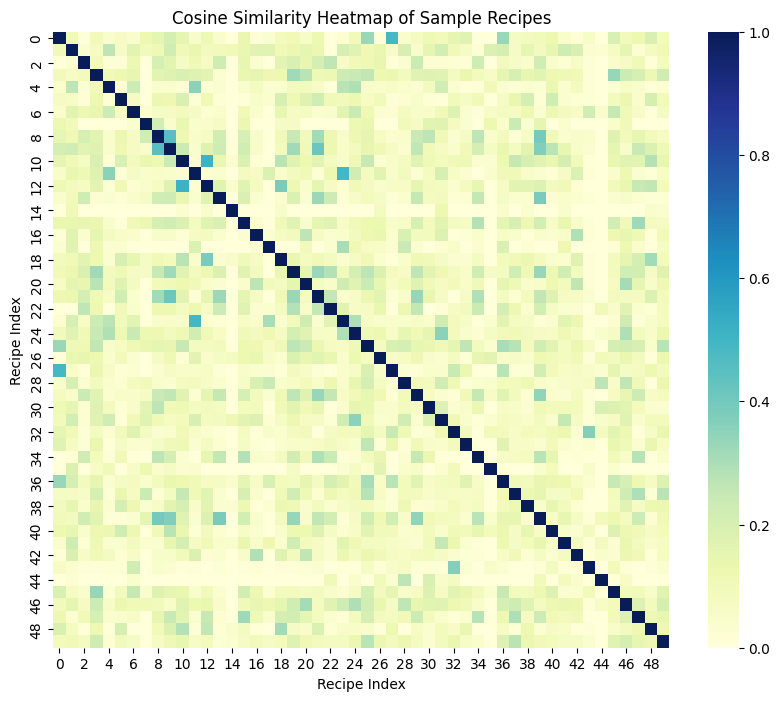

In [38]:
# Create a heatmap for a sample of the cosine similarity matrix
sample_indices = np.random.choice(cosine_sim.shape[0], size=50, replace=False)
sample_cosine_sim = cosine_sim[sample_indices][:, sample_indices]

plt.figure(figsize=(10, 8))
sns.heatmap(sample_cosine_sim, cmap='YlGnBu', square=True)
plt.title('Cosine Similarity Heatmap of Sample Recipes')
plt.xlabel('Recipe Index')
plt.ylabel('Recipe Index')
plt.show()

Distribution of Recommendations to see if certain cuisines are preferred.

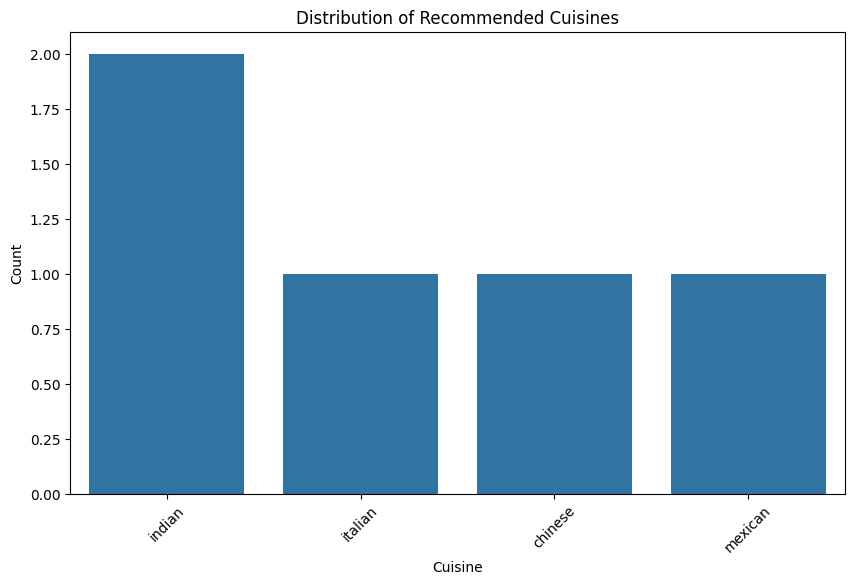

In [39]:
recommended_cuisines = recommendations['cuisine'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=recommended_cuisines.index, y=recommended_cuisines.values)
plt.title('Distribution of Recommended Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Boxplot of Recipe to compare the lengths of the actual recipes vs the recommended ingredient

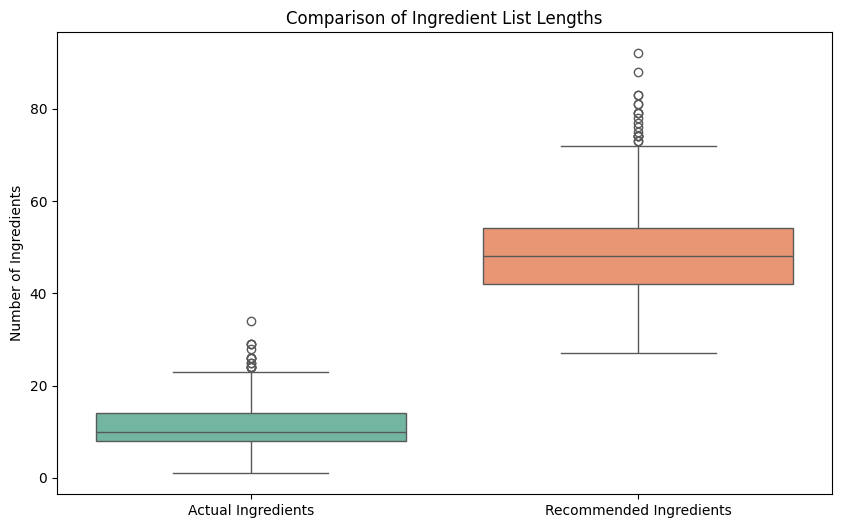

In [40]:
# Calculate lengths
actual_lengths = [len(ingredients) for ingredients in actual_ingredients]
recommended_lengths = [len(ingredients) for ingredients in recommended_ingredients]

plt.figure(figsize=(10, 6))
sns.boxplot(data=[actual_lengths, recommended_lengths], palette="Set2")
plt.xticks([0, 1], ['Actual Ingredients', 'Recommended Ingredients'])
plt.title('Comparison of Ingredient List Lengths')
plt.ylabel('Number of Ingredients')
plt.show()

Word Cloud of Recommended Ingredients

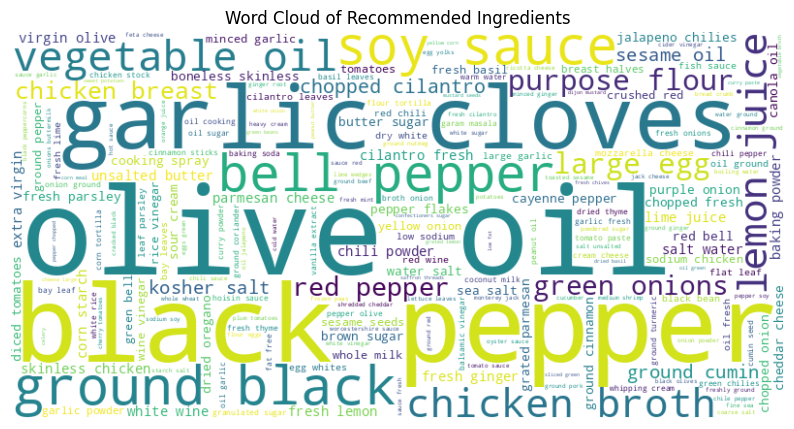

In [41]:
# Combine all recommended ingredients into a single string
all_recommended_ingredients = ' '.join([ingredient for sublist in recommended_ingredients for ingredient in sublist])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_recommended_ingredients)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Recommended Ingredients')
plt.show()
